# Machine Learning Foundation

## Course 5, Part h: Autoencoders LAB

## Learning Objectives 

1. Implement the following dimensionality reduction techniques on the MNIST data:
    * PCA
    * Autoencoders
    * Variational autoencoders
2. Use appropriate scoring metrics to compare the performance of each.

## MNIST data

Throughout this lesson, we'll be working with the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains 70,000 handwritten black-and-white images (digits), which are traditionally split into 60k training images and 10k validation images.

In [1]:
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data();

11501568/11490434 [==============================] - 1s 0us/step


In [2]:
x_train.shape
#black and white so not 3 dimensional RGB, would be (60000, 28, 28, 3)
#x_train[0] each pixel represents some number between 0 and 255 representing the brightness

(60000, 28, 28)

### Preprocess MNIST

We'll preprocess by scaling images pixels to be between 0 and 1.

In [11]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Part 1: PCA

We'll use PCA as a baseline with which we can compare our deep learning models.

For PCA we'll treat each image like a "row" of data and flatten our data, so each observation is 784 columns:

In [12]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


Recall that PCA will do a **matrix decomposition** of this data to find the **eigenvalues** - these **eigenvalues** will be the **principal components** of the data, or the "latent features" that describe a maximal amount of variance in the data.

PCA works better if our features are scaled, so let's do that. 

In [5]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [6]:
from sklearn.decomposition import PCA
#n_components - number of components we want to reduce our data by

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

In [7]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)
#Amount of variance explained by each one of our components
#Variance explained with 784 components: 1.0 - makes sense as we are using all features

Variance explained with 784 components: 1.0


In [ ]:
fit_pca.explained_variance_ratio_
# For each individual component what is the marginal amount of variance explained

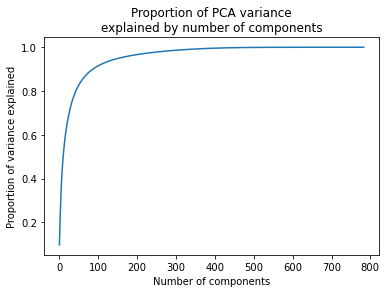

In [8]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

We need about 250 components to explain 90% of the variance in the data!

For visualization purposes, let's extract just two components and plot them:
- Idea being for these two features are we able to see clusters in teh data for each label

In [9]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.17


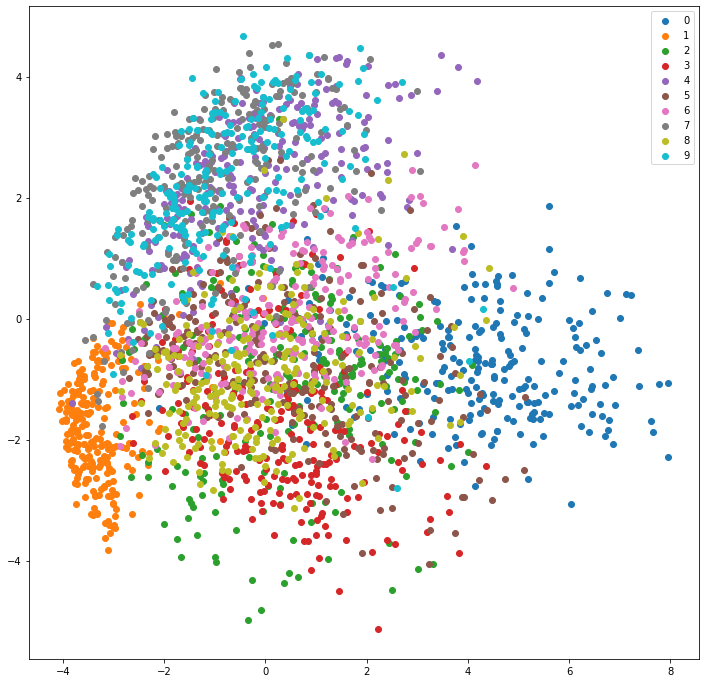

In [10]:
num_images_per_class = 250
fig = plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask = y_train == number #mask essentiall obtains each row from other daat where your criteria is true, pretty cool, the number after is the column
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend();

We can already see that the latent features PCA is learning _somewhat_ disentangle the features here, and a neural network could certainly help with this.

### Scoring PCA

What we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?

As with all models, we should test performance on a different dataset than we trained on:

In [11]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.86


In [12]:
s = MinMaxScaler().fit(x_test_flat) # scale the test data as we did for train
x_test_scaled = s.transform(x_test_flat)

In [13]:
x_test_flat_64 = pca_64.transform(x_test_scaled) # Run the same PCA on the test data
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64) # reconstruct back to the 784 dimensional image, this is teh reconstructing the image we are trying to do

In [14]:
x_test_reconstructed_64.shape

(10000, 784)

In [15]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [16]:
true.shape[1]

784

mean squared error of the reconstructed, sum of difference in values^2/num of features
$$ MSE = \sum  \frac{(x_{true}-x_{reconstructed})^{2}}{No of features} $$

In [17]:
# mean squared error of the reconstructed, sum of difference in values^2/num of features
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [18]:
mse_reconstruction(true, reconstructed)

90.581

Average MSE of **90.6**, using 64 components, for PCA.

### Simple AE - Same thing but using Neural Net

Now let's build an autoencoder! Fundamentally, an autoencoder is an neural network where the input is the same as the output. The hope for such networks is that one of the hidden layers will "learn a compressed representation" of the data, similar to the way PCA does.

In [19]:
from keras.layers import Input, Dense
from keras.models import Model

In [ ]:
# Instead of adding dense layers like before we will use the functional API
# helps with using inception, resnet

In practice, when implementing autoencoders using `Keras`, we define _three_ models:

* The "full autoencoder", here `full_model`, will take inputs and try to reconstruct them
* The "encoder", here `encoder_model`, will take inputs and try to reconstruct them
* The "decoder", here `decoder_model`, will take the latent space and try to reconstruct it

In [20]:
ENCODING_DIM = 64 #same as pca

# Encoder model
inputs = Input(shape=(784,)) # creates a blank tensor, i.e. an array
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs) # dense layer, how many hidden layers and activation
encoder_model = Model(inputs, encoded, name='encoder') # call inputs and outputs, so long as they match up despite adding in more layers (which is below) it will work

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs) # reconstructing the image back up to our dimensions
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae') # initial inputs and final output from decoder(encoder(inputs))

In [21]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [22]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.2116 - accuracy: 0.0122


In [24]:
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                50240     
                                                                 
 decoder (Functional)        (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


Feel free to do `.summary` and `visual` on this trained model now.

Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!

In [25]:
#encoder_model has been fit to the data so we can now predict values - reduce dimensionality
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape #reduce dimensionality

(10000, 64)

So, the "encoder model" has already been trained! For example, the encoding for the first image in the test dataset is:

In [26]:
encoded_images[0]

array([9.26e-01, 6.64e-01, 1.00e+00, 1.00e+00, 6.30e-01, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 3.70e-02, 1.00e+00,
       1.00e+00, 9.98e-01, 1.00e+00, 1.00e+00, 1.00e+00, 3.29e-03,
       1.00e+00, 9.98e-01, 3.66e-03, 8.34e-01, 1.00e+00, 6.26e-01,
       1.00e+00, 2.25e-03, 1.00e+00, 1.00e+00, 9.97e-01, 7.78e-01,
       8.92e-01, 2.95e-02, 1.00e+00, 8.79e-01, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 9.60e-02, 9.98e-01, 1.00e+00, 1.00e+00,
       9.72e-01, 1.00e+00, 1.00e+00, 3.37e-05, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 3.32e-02, 1.00e+00, 1.00e+00, 1.00e+00,
       2.15e-02, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.87e-02, 1.00e+00, 4.17e-03, 1.00e+00], dtype=float32)

As we can see, the `encoder_model` has been trained!

Our goal is now to see what the reconstraction error is.

### Exercise 1

With PCA, we compared the pixel-wise difference between the reconstructed images and the original images to score how good the model was. 

Your task is now to do the same using the autoencoder. You'll have to think about what needs to get fed through the autoencoder to do this. Your steps are:

1. Use the trained autoencoder to generate reconstructed images.
2. Compute the pixel-wise distance between the reconstructed images and the original images. 

Is your result higher or lower than what you got with PCA?

In [27]:
### BEGIN SOLUTION
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat) # full_model will encode and decode the input
mse_reconstruction(decoded_images, x_test_flat) # run out function to see how it evaluates
### END SOLUTION

342.79135

<b> Significantly worse! </b>\
Could have ran for more epochs.\
Even with 5 epochs it still does worse.\
Make a deeper network (as below).

### Exercise 2:

One of the reasons this model does worse than PCA is that is isn't a "Deep Learning" model. Go ahead and add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.

In [32]:
ENCODING_DIM = 64
HIDDEN_DIM = 256 # hidden dimension
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(784,)) #initiate tensor
#encoded = Dense(ENCODING_DIM, activation="relu")(inputs) # fully connected layer
#encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded) # hidden layer
#above in the wrong order, was essentially not including the hidden layer
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(inputs)
encoded = Dense(ENCODING_DIM, activation="relu")(encoder_hidden)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding') # decoding reduced latent space
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs) # hidden layer
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden) # Reconstructing the image
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [33]:
full_model.summary()

Model: "full_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                217408    
                                                                 
 decoder (Functional)        (None, 784)               218128    
                                                                 
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
_________________________________________________________________


In [36]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [37]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=5, batch_size=32)
#will run the gradient every 32 samples and will run through the whole data twice

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0899 - accuracy: 0.0137
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0860 - accuracy: 0.0145
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0836 - accuracy: 0.0148
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0819 - accuracy: 0.0147
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0807 - accuracy: 0.0157


In [38]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

58.64189

Much Better than PCA!\
- Notice loss continued to go down, hasnt slowed so we can do further training and accuracy continued to go up. So increase for epochs.

### Exercise 3:

You've probably noticed we've only been training our model for one epoch. Let's test to see how our model's reconstruction loss decreases as we train it more. 

Write code that:

1. Trains the autoencoder for 5 epochs
2. Prints the reconstruction loss after each epoch

Does the reconstruction loss decrease after each epoch?

In [39]:
def train_ae_epochs(num_epochs=1):
### BEGIN SOLUTION
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    # Encoder model
    inputs = Input(shape=(784,)) 
    encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
    encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
    encoder_model = Model(inputs, encoded, name='encoder')

    # Decoder model
    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')
    
    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32) # when we dont reinitiate the model epochs=1 
                                                                                                    # picks up the training where the last one finished
    
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))
### END SOLUTION       
    return mse_res


In [40]:
train_ae_epochs(10)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.1181 - accuracy: 0.0110
Reconstruction loss after epoch 1 is 99.15093994140625
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0869 - accuracy: 0.0130
Reconstruction loss after epoch 2 is 76.20194244384766
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0818 - accuracy: 0.0133
Reconstruction loss after epoch 3 is 55.90629959106445
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0791 - accuracy: 0.0144
Reconstruction loss after epoch 4 is 49.74542236328125
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0775 - accuracy: 0.0146
Reconstruction loss after epoch 5 is 45.20719909667969
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0764 - accuracy: 0.0148
Reconstruction loss after epoch 6 is 43.995601654052734
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0756 - accuracy: 0.0143
Reconstruction loss after epoch 

[99.15094,
 76.20194,
 55.9063,
 49.745422,
 45.2072,
 43.9956,
 47.302773,
 43.64578,
 47.210033,
 39.89166]

This is promising: even though the loss and accuracy don't appear to be changing much, as we train our autoencoder for longer, it does appear to be getting better and better at reconstructing the (unseen) test images.\
Until we hit 7 epochs and it goes back up but still finishes lower. Loss still decreases through out.

### Variational autoencoder

VAEs are a way have neural networks learn representations of data, as with regular autoencoders. This time, however, the neural network will learn parameters of a normal distribution that will have observations drawn from it that will be transformed back into images. This results in two dimensional latent representation of the data once the variational autoencoder is trained, where one dimension represents the mean of the normal distribution and the other dimension represents the standard deviation.

At a high level, the actual steps of a VAE are:

1. The first neural network, the <b>"encoder"</b>, predicts two vectors for each image, which will then be interpreted as means and standard deviations and transformed into a normal distribution.
3. The second neural network, the <b>"decoder"</b>, takes the results of this operation and tries to reconstruct the original image.
4. The entire system is trained with <b>backpropagation</b>. At each iteration, _two_ losses are computed:
    * One loss simply penalizes the system for producing images that don't match the original images.
    * The other loss penalizes the encoder model for not correctly producing statistics from the image that match a standard normal distribution. 
   
The details are contained in the presentation. 

In [33]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

The function below involves transforming the VAE encoder outputs into a normally distributed output. 

Recall that the VAE encoder generates vectors representing $\mu$ and $log(\sigma)$. These are then transformed into the generator input via 

$$ G_{in} = \mu + \sigma * \epsilon $$

where $ \epsilon $ ~ $ N(0, 1) $. $ \epsilon$ is the random noise.

In [34]:
def sampling(args):
    """
    Transforms parameters defining the latent space into a normal distribution.
    """
    # Need to unpack arguments like this because of the way the Keras "Lambda" function works.
    mu, log_sigma = args
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=tf.shape(mu))
    sigma = K.exp(log_sigma) # remember we use the log so its always positive
    return mu + K.exp(0.5 * sigma) * epsilon

In [35]:
# Create encoder network
hidden_dim = 256
batch_size = 128
latent_dim = 2 
# this is the dimension of each of the vectors representing the two parameters
# that will get transformed into a normal distribution
epochs = 1


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(784, ), name='encoder_input')
x = Dense(hidden_dim, activation='relu')(inputs)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# NOTE: output of encoder model is *2* n-dimensional vectors:

z = Lambda(sampling, name='z')([z_mean, z_log_var])
# z is now one n dimensional vector representing the inputs 
encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder') # outputs 3 values

We'll have the `encoder_model` output `z_mean`, `z_log_var`, and `z` so we can plot the images as a function of these later.

In [44]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,),) # 2 dimensions
x = Dense(hidden_dim, activation='relu')(latent_inputs) #expand using hidden layer
outputs = Dense(784, activation='sigmoid')(x) # reconstruct
decoder_model = Model(latent_inputs, outputs, name='decoder')


# instantiate VAE model
outputs = decoder_model(encoder_model(inputs)[2]) # note here as input we only want our third value which is our z value
vae_model = Model(inputs, outputs, name='vae_mlp')

#### Examine each layer

In [45]:
for i, layer in enumerate(vae_model.layers):
    print("Layer", i+1)
    print("Name", layer.name)
    print("Input shape", layer.input_shape)
    print("Output shape", layer.output_shape)
    if not layer.weights:
        print("No weights for this layer")
        continue
    for i, weight in enumerate(layer.weights):
        print("Weights", i+1)
        print("Name", weight.name)
        print("Weights shape:", weight.shape.as_list())

Layer 1
Name encoder_input
Input shape [(None, 784)]
Output shape [(None, 784)]
No weights for this layer
Layer 2
Name encoder
Input shape (None, 784)
Output shape [(None, 2), (None, 2), (None, 2)]
Weights 1
Name dense_6/kernel:0
Weights shape: [784, 256]
Weights 2
Name dense_6/bias:0
Weights shape: [256]
Weights 3
Name z_mean/kernel:0
Weights shape: [256, 2]
Weights 4
Name z_mean/bias:0
Weights shape: [2]
Weights 5
Name z_log_var/kernel:0
Weights shape: [256, 2]
Weights 6
Name z_log_var/bias:0
Weights shape: [2]
Layer 3
Name decoder
Input shape (None, 2)
Output shape (None, 784)
Weights 1
Name dense_9/kernel:0
Weights shape: [2, 256]
Weights 2
Name dense_9/bias:0
Weights shape: [256]
Weights 3
Name dense_10/kernel:0
Weights shape: [256, 784]
Weights 4
Name dense_10/bias:0
Weights shape: [784]


Layer 1 - No weights being learned. None is how many samples we pass in.\
Layer 2 - 3 dimensional out, means, sigmas and sampled values. We have a dense layer for weights 1, [784, 256]. Weights 2 bias term (256). Weights 3 mean values [256,2]. Weights 4 mean bias of 2 values. Then weights 5 and 6 are the same for the log variance.\
Layer 3 - Decoder with input of 2, output of actual dims. All the intermediate weights there.

<b>If we want to compile the model we need to create the loss functions used to optimize. </b>

### Review of variational autoencoder loss:

**Part 1:**

We know Variational Autoencoders use the first part of their architecture - the encoder - to output zeros for the mean and zeros for the log variance (equal to a "real" variance of 1). 

We also know that the penalty for a given prediction of $\mu_{pred}$ and $log(\sigma)_{pred}$ is:

$$
\frac{1}{2} * (e^{log(\sigma)_{pred}} - (1 + log(\sigma)_{pred}) + (\mu_{pred})^2 )
$$

* **Note 1**: we predict $\log(\sigma)$ because predicting $\sigma$ directly could result in a negative value, and having a negative value for the variance of a distribution makes no sense.
* **Note 2**: the cost function has two components, both of which penalize us for having results that deviate from a standard normal distribution.
    * The first part penalizes the $log(\sigma)_{pred}$ from being away from 0, using the fact that $e^x - (x+1)$ is minimized at $x=0$.
    * The second part simply penalizes $\mu_{pred}$ from being away from 0.

This loss, representing a measure of the difference between these two distributions, is called the **KL Loss**.

**Part 2:**

The other part of the loss is simply the difference between the outputted image and the image fed in. The standard way of penalizing a difference between these two quantities is to use a `binary_crossentropy` function.

### Exercise 4:

Compute the loss for variational autoencoders. It should have two components:

1. The reconstruction loss. Use the `binary_crossentropy` Keras function to compute the loss. 
    
    **Note**: The `binary_crossentropy` function returns an average by default, so we  multiply this component of the loss by the number of pixels in the image (784) to get the total loss.
    
2. The KL loss. Use the formula above, and the `z_mean` and `z_log_var` functions to fill in the missing piece below.
    
    **Note**: We sum across the latent dimension to get a total loss for each input image.
    
Fill in the missing pieces:

In [46]:
#reconstruction_loss = # YOUR CODE HERE
#reconstruction_loss *= 784

In [47]:
#kl_loss = # YOUR CODE HERE
#kl_loss = K.sum(kl_loss, axis=-1)
#total_vae_loss = K.mean(reconstruction_loss + kl_loss)

In [48]:
### BEGIN SOLUTION
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784 #so we arent working with the average value but the full value

In [49]:
kl_loss = 0.5 * (K.exp(z_log_var) - (1 + z_log_var) + K.square(z_mean))
kl_loss = K.sum(kl_loss, axis=-1)
total_vae_loss = K.mean(reconstruction_loss + kl_loss)
### END SOLUTION

### Compiling and fitting the model

In [50]:
vae_model.add_loss(total_vae_loss) #adding our new loss function to our model

vae_model.compile(optimizer='rmsprop',
                  metrics=['accuracy'])
    
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[1][2]']                
                                                                                            

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [51]:
vae_model.fit(x_train_flat,
        epochs=epochs,
        batch_size=batch_size)

AttributeError: in user code:

    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/training.py", line 817, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 439, in update_state
        self.build(y_pred, y_true)
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 359, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 485, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 485, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 506, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'NoneType' object has no attribute 'shape'


### Exercise 5:

Compute the reconstruction error for the variational autoencoder. Is it higher or lower than for the autoencoder was after one epoch? Why do you think that is?

In [41]:
### BEGIN SOLUTION
# Generate reconstructed images
decoded_images = vae_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

550.807

Much higher ("worse")! This is because a variational auto encoder is designed to maximize the interpretability (ie sampling from a distribution) of the latent space, _not_ to minimize reconstruction error. 

Below, we'll show how you can visualize the latent space that this variational autoencoder has learned:

#### Plotting the latent space:

In [17]:
models = encoder_model, decoder_model 
data = x_test_flat, y_test

In [18]:
def plot_results_var(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist",
                    lim=4):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    
    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size=batch_size)
    #_, z_log_var, _ = encoder.predict(x_test,
    #                               batch_size=batch_size)
    print(z_log_var)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=y_test) #colour in scatter according to y test
    plt.colorbar()
    plt.xlabel("z[0]") # random samples we pull out
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    # grid space based on our limit, in our case 4 with n=30 values for x and y
    grid_x = np.linspace(-1.0 * lim, lim, n)
    grid_y = np.linspace(-1.0 * lim, lim, n)[::-1]

    # generate images based on the random sample
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample) # samples from a normal dist
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

[[-0.16 -0.13]
 [ 0.27 -0.27]
 [ 0.12 -0.21]
 ...
 [-0.42  0.17]
 [-0.2  -0.33]
 [-0.41  0.8 ]]


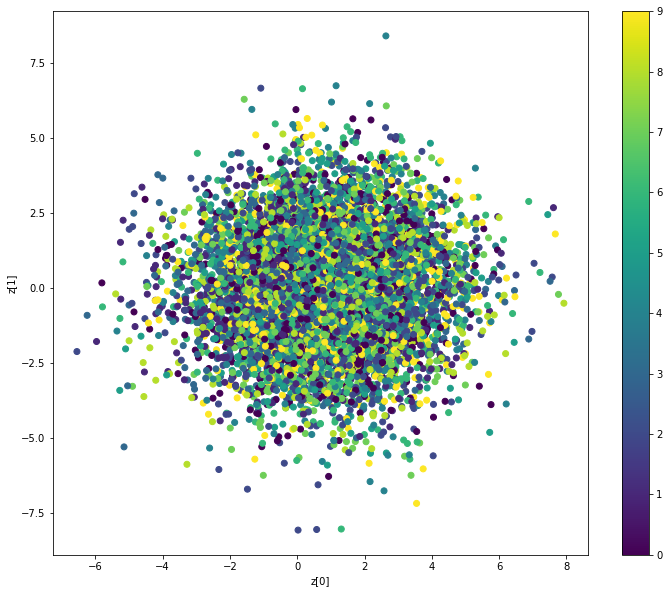

KeyboardInterrupt: 

In [19]:
# doesnt work properly as we cant fit the model
plot_results_var(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp", 
             lim=5)

Interesting results for just one epoch! As with the autoencoder above, you can modify the architecture of the VAE to try and produce better results, even adding convolutions.

### Exercise 6

Train VAE and AE for 10 epochs each, and plot the reconstruction MSE as a function of the number of epochs for each. Which one seems to have more potential to continuously learn as it is given more compute time? Is this surprising to you?

In [45]:
### BEGIN SOLUTION 
# Gather AE loss 
loss_ae = train_ae_epochs(10)

Epoch 1/1
60000/60000 [==============================] - 23s 391us/step - loss: 0.1184 - accuracy: 0.8106
Reconstruction loss after epoch 1 is 90.10858154296875
Epoch 1/1
60000/60000 [==============================] - 22s 370us/step - loss: 0.0870 - accuracy: 0.8146
Reconstruction loss after epoch 2 is 75.51473999023438
Epoch 1/1
60000/60000 [==============================] - 23s 383us/step - loss: 0.0818 - accuracy: 0.8149
Reconstruction loss after epoch 3 is 57.27885818481445
Epoch 1/1
60000/60000 [==============================] - 23s 386us/step - loss: 0.0792 - accuracy: 0.8151
Reconstruction loss after epoch 4 is 56.72281265258789
Epoch 1/1
60000/60000 [==============================] - 23s 379us/step - loss: 0.0776 - accuracy: 0.8152
Reconstruction loss after epoch 5 is 54.57322311401367
Epoch 1/1
60000/60000 [==============================] - 24s 397us/step - loss: 0.0766 - accuracy: 0.8152
Reconstruction loss after epoch 6 is 47.52267837524414
Epoch 1/1
60000/60000 [===========

In [46]:
# VAE model loss

In [47]:
vae_mse = []
for i in range(10):
    vae_model.fit(x_train_flat,
            epochs=1,
            batch_size=batch_size)
    decoded_images = vae_model.predict(x_test_flat)
    vae_mse.append(mse_reconstruction(decoded_images, x_test_flat))

Epoch 1/1
60000/60000 [==============================] - 11s 177us/step - loss: 182.5646
Epoch 1/1
60000/60000 [==============================] - 9s 146us/step - loss: 181.3384
Epoch 1/1
60000/60000 [==============================] - 9s 147us/step - loss: 180.6766
Epoch 1/1
60000/60000 [==============================] - 8s 141us/step - loss: 180.0886
Epoch 1/1
60000/60000 [==============================] - 8s 134us/step - loss: 179.7263
Epoch 1/1
60000/60000 [==============================] - 8s 138us/step - loss: 179.4685 0s - loss: 179.520 - ETA: 0s - loss: 179.5
Epoch 1/1
60000/60000 [==============================] - 8s 142us/step - loss: 179.1626
Epoch 1/1
60000/60000 [==============================] - 8s 140us/step - loss: 178.9184
Epoch 1/1
60000/60000 [==============================] - 9s 154us/step - loss: 178.7946
Epoch 1/1
60000/60000 [==============================] - 9s 156us/step - loss: 178.5206


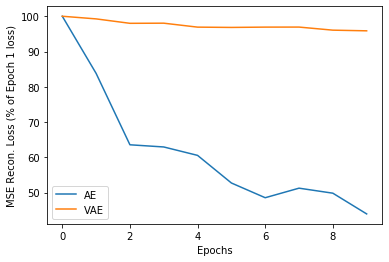

In [48]:
# Plot scaled losses
plt.plot(range(10), loss_ae/(.01*loss_ae[0]), label='AE')
plt.plot(range(10), vae_mse/(.01*vae_mse[0]), label='VAE')
plt.xlabel('Epochs')
plt.ylabel('MSE Recon. Loss (% of Epoch 1 loss)')
plt.legend()
### END SOLUTION 

---
### Machine Learning Foundation (C) 2020 IBM Corporation